# Übung 1: Backpropagation für Mehrschichtenperzeptronen

In [1]:
import os, sys, importlib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [2]:
# Load modules from modules directory
base_path_modules = os.path.join(os.getcwd(), "..", "modules")
sys.path.append(base_path_modules)
import load_mnist
importlib.reload(load_mnist)

<module 'load_mnist' from '/home/jovyan/work/../modules/load_mnist.py'>

### 1. Spielzeugdatensatz

Laden Sie sich das Jupyter-Notebook "Training eines MLPs auf MNIST" von der Vorlesungsseite auf Moodle herunter, das den Numpy-Code für den Backpropagation-Agortihmus für den MLPs enthält. Statt auf MNIST werden wir zunächst ein einfacheres Perzeptron auf den Spielzeugdaten aus der Vorlesung trainieren.

In [3]:
base_path_datasets = os.path.join(os.getcwd(), "..", "datasets")
mnist_train = datasets.MNIST(root = base_path_datasets, train = True, download = True, transform = True)
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/jovyan/work/../datasets
    Split: Train

In [4]:
mnist_test = datasets.MNIST(root = base_path_datasets, train = False, download = True, transform = True)
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: /home/jovyan/work/../datasets
    Split: Test

#### Vorgehensweise:
1. Erzeugen Sie 200 zweidimensionale Trainingsdatenpunkte mithilfe einer Gleichverteilung über dem Gebiet [-6,6]  x [-6,6]. Speichern Sie diese in einer 200 x 2 Designmatrix.
2. Die Klassenlabels 0 und 1 werden so vergeben, dass alle Datenpunkte im 1. und 3. Quadranten das Label 1 und im 2. und 4. Quadranten das Label 0 erhalten. Speichern Sie die Labels in einem Array.
3. Erzeugen Sie einen gleich großen Testdatensatz nach demselben Prinzip stellen Sie beide Datensätze zur Überprüfung als Scatterplot dar.

In [5]:
# Uniformly distributed training-data over intervall [-6, 6]
x_train = np.random.uniform(-6, 6, (200, 2))
x_train

array([[-2.95764933,  0.38766809],
       [ 4.77227428,  1.17449364],
       [ 0.27672575, -1.92496371],
       [ 3.56923503,  2.90153668],
       [ 5.7770081 ,  1.01214401],
       [ 5.50172956, -1.57134317],
       [-3.36933259,  1.87427631],
       [-2.5606885 , -3.39443411],
       [ 5.60698453, -5.08258367],
       [-3.59676232, -2.12401145],
       [ 2.89339793, -1.16813549],
       [-2.68659969, -1.87321828],
       [ 4.77858635, -3.44505333],
       [-5.1753069 ,  2.04640478],
       [ 5.18291482, -4.63108986],
       [-2.89819672, -5.37747193],
       [ 3.34779971,  5.93937744],
       [-4.95851524, -5.92702017],
       [-4.88301106, -2.35893193],
       [-1.06528202, -4.09800303],
       [ 5.27010919,  0.51527174],
       [-1.8131386 ,  2.32971561],
       [ 4.53356792, -5.49076198],
       [ 4.80686431,  0.45913066],
       [ 4.18023686, -3.1498257 ],
       [ 4.90230716, -0.13925638],
       [-1.6235761 , -1.33223852],
       [-5.03599373, -0.68768616],
       [-1.5710336 ,

In [6]:
x_train.shape

(200, 2)

In [7]:
# Create training set labels
check_1d_quad = np.logical_and(x_train.T[0] > 0, x_train.T[1] > 0)
check_3d_quad = np.logical_and(x_train.T[0] < 0, x_train.T[1] < 0)
check_rev = np.logical_or(check_1d_quad, check_3d_quad)
y_train = np.where(check_rev, 1, 0)
y_train

array([0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1])

In [8]:
y_train.shape

(200,)

In [9]:
# stack data into frame
stacked = np.vstack((x_train.T, y_train))
pseudo_data = pd.DataFrame(stacked)
pseudo_data.T.head()

,0,1,2
0,-2.957649,0.387668,0.0
1,4.772274,1.174494,1.0
2,0.276726,-1.924964,0.0
3,3.569235,2.901537,1.0
4,5.777008,1.012144,1.0


In [10]:
def gen_data(samples = 200):
    """
        Generate uniformly distributed data points over [-6, 6] x [-6, 6] of shape (200, 2)
        
        Parrameter:
        - samples: amount of random samples to generate 
        
        return (data, label)
    """
    x_train = np.random.uniform(-6, 6, (samples, 2))
    
    check_1d_quad = np.logical_and(x_train.T[0] > 0, x_train.T[1] > 0)
    check_3d_quad = np.logical_and(x_train.T[0] < 0, x_train.T[1] < 0)
    check_rev = np.logical_or(check_1d_quad, check_3d_quad)
    y_train = np.where(check_rev, 1, 0)
    
    return (x_train, y_train)

# Put train/test data together into a frame for plotting
def get_frame(train, test):
    return pd.DataFrame(np.vstack((train.T, test)), index = [0, 1, "label"])

def plot_data(frame):
    sns.scatterplot(data = frame.T, x = 0, y = 1, hue = "label")

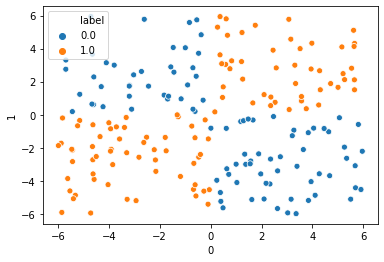

In [11]:
(x_train, y_train) = gen_data()
train_df = get_frame(x_train, y_train)
plot_data(train_df)

In [12]:
train_df.T.describe()

,0,1,label
count,200.000000,200.000000,200.000000
mean,0.026116,-0.404870,0.535000
std,3.420780,3.162449,0.500025
min,-5.980599,-5.986609,0.000000
25%,-3.044704,-2.949399,0.000000
50%,0.256731,-0.449028,1.000000
75%,2.811156,2.111900,1.000000
max,5.958243,5.940519,1.000000


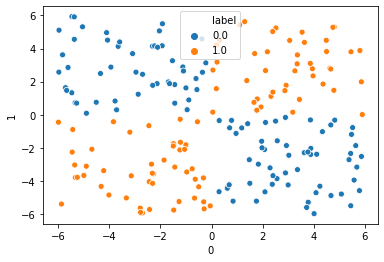

In [13]:
(x_test, y_test) = gen_data()
test_df = get_frame(x_test, y_test)
plot_data(test_df)

In [14]:
test_df.T.describe()

,0,1,label
count,200.000000,200.000000,200.000000
mean,0.156669,-0.269396,0.465000
std,3.440261,3.387369,0.500025
min,-5.997047,-5.982463,0.000000
25%,-2.370537,-3.283442,0.000000
50%,0.119780,-0.347871,0.000000
75%,3.034790,2.644496,1.000000
max,5.901760,5.936537,1.000000


4. Das in der Vorlesung dargestellte Experiment operiert nicht direkt auf den Inputdaten, sondern auf 2 Merkmale, die mithilfe zweier neuroren mit fixem Geichtsvektor berechnet werden: ein Neuron teilt die Inputebene waagrecht entlang der x-Achse, das andere senkrecht entlang der y-Achse. Wie muss der Gewichtsvektor für das jeweilige Neuron aussehen?


- Gewichtvektor erstes Neuron [1,0] 
- Gewichtsvektor zweites Neuron [0,1]

5. Berechnen Sie die Entscheidungsfunktion beider Neuronen mit der im Beispielcode angegebenen sigmoiden Aktiviterungsfunktion auf einem 100 x 100 Gitter innerhalb des gebiets [-6, 6]x [-6, 6] und stellen Sie diese zur Überprüfung als Farbbild dar.

In [15]:
sigmoid = lambda x: 1/(1+np.exp(-x))
sigmoid_prime = lambda x: sigmoid(x) + (1- sigmoid(x))

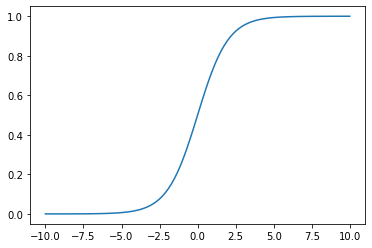

In [16]:
# Sigmoid function
x = np.linspace(-10, 10, 100)
z = sigmoid(x)

plt.plot(x, z)
plt.show()

In [17]:
value_space = np.linspace(-6, 6, 200)
extended_sig = lambda x: sigmoid(np.sqrt(x))
sig_vect = np.vectorize(sigmoid)

In [18]:
def create_grid(dim):
    """
        Create a grid with the given dimensions
    """
    values_direction = np.linspace(-6, 6, dim)
    return np.array(np.meshgrid(values_direction, values_direction)).T.reshape(-1, dim, 2);
    

def calc_activation(weights, activation = sig_vect, shape = (100, 100)):
    """
        Creates an image plot out of given weights.
    
        intput:
         - weights: to use for calculation with dimension (2,)
         - activation: activation function to use in vectorized form
         - shape: shape of grid to be generated
    """
    
    x_dimension, y_dimension = shape
    weights_matrix = np.zeros((x_dimension, 2)) + weights
    
    # Create a grid for calculation
    # values_direction = np.linspace(-6, 6, x_dimension)
    # grid = np.array(np.meshgrid(values_direction, values_direction)).T.reshape(-1, x_dimension, 2)
    
    grid = create_grid(x_dimension)
    
    # Calculate the mse and use sigmoid activation
    weighted_values = grid * weights_matrix # (100, 100, 2)
    summed_values = np.sum(weighted_values, axis = 2) # (100, 100)
    calculated = sig_vect(summed_values) # use activation function on cell values
    return calculated

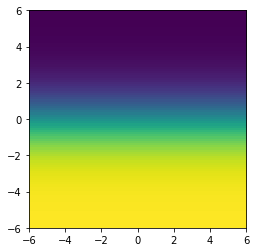

In [19]:
first_neuron_weight = np.array([1, 0])
output_first_neuron = calc_activation(first_neuron_weight)
plt.imshow(output_first_neuron, extent = [-6,6,-6,6]) 

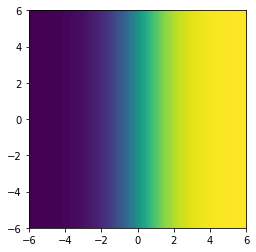

In [20]:
second_neuron_weight = np.array([0,1])
output_sec_neuron = calc_activation(second_neuron_weight)
plt.imshow(output_sec_neuron, extent = [-6,6,-6,6]) 

6. Da die Eingangsneuronen nicht mittrainiert werden, können wir deren Output schon im Vorfeld berechnen. Erzeugen Sie dazu neue Designmatrizen für den Trainings und Testddatensatz, so dass die erste Spalte den Ouput des ersten Neurons und die zweite Spalte den Ouput des zweiten Neurons enhält. Erzeugen Sie auch eine entsprechende Designmatrix für Ihr 100 x 100-Gitter, die wir später zu Darstellungszwecken brauchen werden. Wichtig: arbeiten Sie im Folgenden nur mit diesen transformierten Designmatrizen, um korrekte Ergebenisse zu erhalten!

In [21]:
(x_train, y_train) = gen_data(100)

# Weights for the neurons
weights_first_neuron = np.zeros((100,2)) + np.array([0,1])
weights_second_neuron = np.zeros((100,2)) +np.array([1,0])

# Calculate output values for each neuron
output_first_n = sig_vect(np.sum(x_train * weights_first_neuron, axis = 1))
output_second_n = sig_vect(np.sum(x_train * weights_second_neuron, axis = 1))

In [22]:
# Concat neuron values
input_output_layer = np.vstack((output_first_n, output_second_n)).T
input_output_layer.shape

(100, 2)

### 2. Training eines MLPs auf den Spelzeugaten
Der Code aus dem Beispielnotebook muss zunächst andas Szenario aus der Vorlesung angepasst werden: ein deutlich kleineres Netzwerk mit eindimensionalen statt zehndimensioanlem Output.

---
Vorgehensweise:
1. Setzten Sie im Code die Größe der Minibatches auf 10, die Anzahl der Epochen auf 150 und die Lernrate auf 0.03. Ändern Sie die Netzarchitektur so ab, dass sie 2 Eingangsneuronen, 2 verdeckte Schichten mit jeweils 2 Neuronen und 1 Ausgangsneuron haben. Überprüfen Sie die Größen der sich daraus ergebenden Gewichtsmatrizen auf Korrektheit.
2. Der Beispielcode verwendet One-Hot-Coding für die Labels in unserem Beispiel sind die Klassenzugehörigkeiten aber durch die Klassenindizes 0 und 1 codiert. Wir müssen daher die Funktion `evaluate()` im Code so abändern das , das ein Beispiel als korrekt klassifiziert gilt, wenn bei Klasse 0 der MLP-Ouptut kleiner als 0.5 ist und bei Klasse 1 größer als 0.5 Berechnen Sie zusätzlich den MSE in dieser Funktion bei jedem Aufruf und speichern Sie diesen in einem zusätzlichen Array ab.
3. Trainieren Sie Ihr Netz mit den Trainingsdaten als Validierungsdaten und testen Sie es auf Ihren Testdaten. Stellen Sie die Lernkurven für Genauigkeit und MSE als Plots dar. Beachten Sie hierbei, dass unser Lernproblem nicht konvex ist, so dass die Optimierung zuweilen in kokalen Minima hängenbleiben kann. WIederholen Sie ihren Versuch daher mehrere Male und vergleichen Sie die Ergebnisse.
4. Berechnen Sie die Entscheidungsfunktion Ihres MLPs für Ihr 100 x100-Gitter und stellen Sie diese gemeinsam mit dem Scatterplot Ihrer Trainingsdaten dar.

In [23]:
import first_nn
importlib.reload(first_nn)

<module 'first_nn' from '/home/jovyan/work/../modules/first_nn.py'>

In [24]:
network = first_nn.FirstNN(2, 2, 2)

In [25]:
indx = np.random.randint(10, size= (2))

x_train[indx]

array([[ 4.38594616,  0.64576676],
       [-2.60132268,  3.27457848]])

### 3. Nachvolziehen der Beispiele aus der Vorlesung
Das netz aus der Vorlesung verwendet als Aktivierungsfuntkion den *Tangens-hyperbolicus* (`np.tan()`). Passen Sie die Funktion `sigmoid()` und `sigmoid_prime()` entsprechend an. Achtung: kommentieren Sie den biserigen Code für die Sigmoidfunktion nur aus, wir werden ihn in der nächsten Aufgabe nochmals benötigen. Da die AUsgangswerte von *tanh* im Intervall [-1,1] statt [0,1] liegen, müsssen wir hierfür nochmals die Funktion `evaluate()` enstsprechend anpassen. Vollziehen Sie die 3 Beispiele aus der Vorlesung nach.

### 4. Logistische Regression
Eine alternative, besser an das Klassifikationsszenario angepasst Kostenfunktion statt des MSE ist die Kostenfunktion für die logisitische Regression: 

$C$ = -*y* log($a^l$) - (1 - *y*) log(1 - $a^l$)

Damit Sie diese in Ihrem Beispiel aanweden können, müssen Sie die Ableitung $\nabla$<sub>$a^L$</sub>$C$ berechnen und die Funktion `cost_derivative()` entsprechend abändern. Da die logistische Regression davon ausgeht, dass der Output des NEtztes eine Wahrscheinlichkeit zwischen 0 und 1 ist, können wir hierfür nicht den `tanh()` als Aktivierungsfunktion verwenden. Machen Sie daher Ihre Änderungen aus Aufgabe 3 rückgängig, so dass Sie wieder eine sigmoide Aktivierungsfunktion haben. Inder Funktion `evaluate()` sollte natürlich statt des MSE die Kostenfunktion der logistischen Regression ausgegeben werden, um zu überprüfen ob tatsächlich ein Gradientenabstieg stattfindet. Weiterhin ist es nützlich, sowohl auf $C$ wie auf $\nabla$<sub>$a_{L}$</sub>$C$ die Funktion `np.nan_to_num()` anzuwenden, da hier zuweilen numerische Probleme auftreten können.